In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
from snorkel.labeling import labeling_function
from funcoes_graficas import conflict_matrix_show

# Premissas do Trabalho


Esse trabalho tem como objetivo o uso de aprendizado de máquina fracamente supervisionado, para a classificação de petições iniciais sendo na qual tẽm como assunto processual o tema da aposentadoria ou não.

- Nesse trabalho será usado um dataframe a partir das petições inicias extraidas do banco de dados do sistema processual CRETA, na qual foi realizado anteriormente a etapa de OCR para transformar as petições de formato "pdf" e de imagem em textosos_limposos_limposos_limposo na qual é possivel realizar as etapas de PLN e aprendizado de máquina.
- As etapas de preparação dos textosos e retiradas de duplicatas foi realizada anteriormente, e se encontra no arquivo clean.py


- Devido ao grande custo computacional inerente as atividades de vetorização textosos_limposos_limposos_limposos_limposos_limposos_limposos_limposos_limposos_limposual, carregamento em memoria e treinamento dos modelos de aprendizado de máquina, foi utilizado um sample do dataframe completo com apenas 10000 petições de diversos temas.

- A pipeline de supervisão fraca irá consistir nas seguintes etapas:
    1. Escrever as funções de rotulagem (labeling functions)
    2. Treinar um LabelModel
    3. Usar as saidas do LabelModel para treinar um modelo de descriminativo a vim de imputar uma classificação as
     observação

In [ ]:
df=pd.read_parquet('df_textos_limpos_sem_duplicacao.parquet').sample(10000,random_state=10)
df

,id,assunto,texto,textos_limpos
index,,,,
184520,569162,Auxílio-Doença Previdenciário,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,secção assu roque roberio ferreira brasileiro ...
141137,343275,Auxílio-Doença Previdenciário,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,petição inicial auxilio juíz vara orlando pedr...
104403,302450,Auxílio-Doença Previdenciário,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,petição usucapião correspondência eletrônica e...
220395,595364,"Benefício Assistencial (Art. 203,V CF/88)",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,vara federais couber apolonia nogueira lima so...
224237,598455,Aposentadoria por Idade (Art. 48/51),\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,0511220 8400 gilberto alves oliveira devidamen...
...,...,...,...,...
217409,593354,Auxílio-Doença Previdenciário,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,patição inicial karla vara federais natal karl...
46820,258146,Sistema Remuneratório e Benefícios,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...,albano barbalho advogados associados maria lou...
50464,261798,Auxílio-Doença Previdenciário,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,poder judiciário juizados especiais lauro pint...


## Principais Assuntos

Como é possivel observar abaixo um dos prinicipais assuntos presentes nas petições inicias é referente a Aposentadoria e suas variações, o uso de um classificador para indicar se a petição pertence ou não ao tema da Aposentadoria, pode ser beneficial em uma pipeline onde teriamos outro classificador onde diferenciariamos o tipo de processo de aposentadoria, de modo a diminuir o conjunto de possibilidades do classificador. Dessa forma nesse trabalho será utilizado um classificador binário, diminuindo de um problema multiclasse com dezenas de classes para um problema binário.


- Dessa maneiras os assuntos abaixo foram rotulados como aposentadoria.
1. Aposentadoria por Idade (Art. 48/51);
2. Aposentadoria por Invalidez;
3. Aposentadoria Especial (Art. 57/8);
4. Aposentadoria por Tempo de Contribuição (Art. 55/6);
5. Aposentadoria por Tempo de Serviço (Art. 52/4);
6. Aposentadoria por Invalidez Acidentária.

In [ ]:
raking_assuntos=df.assunto.value_counts()
raking_assuntos=pd.DataFrame(raking_assuntos)
raking_assuntos.head(50)

,count
assunto,
Auxílio-Doença Previdenciário,2613
"Benefício Assistencial (Art. 203,V CF/88)",1208
Aposentadoria por Idade (Art. 48/51),1053
Aposentadoria por Invalidez,797
Sistema Remuneratório e Benefícios,618
Pensão por Morte (Art. 74/9),541
Salário-Maternidade (Art. 71/73),464
Parcelas de benefício não pagas,362
Indenização por Dano Moral,300


# Separação dos dados para a supervisão fraca

1. Conjunto de Treinamento

    O conjunto de treinamento terá as 10000 petições retiradas do banco de dados do Creta-JFRN

2. Conjunto de Desenvolvimento

    Conterá 310 petições rotuladas manualmente disponibilizadas pelo LABFERVO

3. Conjunto de validação/teste

    Conterá 310 petições rotuladas manualmente disponibilizadas pelo LABFERVO


In [ ]:
df_dev_teste=pd.read_csv('df_raw.csv')

df_train=df
df_dev_teste.classificacao.value_counts()




classificacao
48 - APOSENTADORIA ESPECIAL                            151
65 - BENEFICIO ASSISTENCIAL - LOAS                      65
57 - SALARIO MATERNIDADE RURAL                          55
45 - APOSENTADORIA IDADE RURAL                          46
35 - PENSAO POR MORTE                                   35
33 - AUXÍLIO-DOENÇA E APOSENTADORIA POR INVALIDEZ       31
29 - REVISIONAL FGTS                                    29
26 - ACAO COBRANCA DPVAT                                26
23 - APOSENTADORIA POR IDADE URBANA                     26
25 - AUXILIO RECLUSAO                                   25
25 - SALARIO MATERNIDADE - URBANA                       25
23 - TRIB - CONTR. PREV. PAGAS ALÉM DO TETO             23
25 - APOSENTADORIA POR TEMPO DE CONTRIBUICAO            21
21 - AUXÍLIO-DOENÇA                                     21
20 - APOSENTADORIA POR IDADE HÍBRIDA (URBANA-RURAL)     20
20 - SAÚDE - FORNECIMENTO DE MEDICAMENTOS               20
20 - AUXÍLIO-EMERGENCIAL                  

In [ ]:
from sklearn.model_selection import train_test_split

df_dev_teste['Classificacao_Binaria'] = df_dev_teste['classificacao'].str.contains('APOSENTADORIA', case=False).astype(int)
df_dev_teste.rename(columns={'conteudo_peticao':'texto'},inplace=True)
df_dev_teste.dropna(inplace=True)


df_teste, df_dev = train_test_split(df_dev_teste, test_size=0.5, random_state=42, stratify=df_dev_teste.Classificacao_Binaria)
df_teste

,Unnamed: 0,nome_documento,texto,conteudo_peticao_limpo,classificacao,Classificacao_Binaria
145,145,testes_50.txt,b'CONDIC~ES AMBIENTAIS DO \r\nTRABALHO \r\nMat...,condic ambientais ntrabalho nmata fresca ltda ...,48 - APOSENTADORIA ESPECIAL,1
271,271,0005532-30.2022.4.05.8302.pdf,['AO JUÍZO FEDERAL DA ____ VARA DO JUIZADO ESP...,pernambuco restabelecimento auxílio doença mar...,33 - AUXÍLIO-DOENÇA E APOSENTADORIA POR INVALIDEZ,1
311,311,Petição inicial - 0028455-56.2022.4.05.8300.pdf,['EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A...,pernambuco romildo araujo pereira filho brasil...,23 - TRIB - CONTR. PREV. PAGAS ALÉM DO TETO,0
107,107,testes_14.txt,b' \r\n \r\n1/13 \r\nEXCELENT\xc3\x8dSSIMO JUI...,nexcelent x8dssimo juizados especiais nmossor ...,48 - APOSENTADORIA ESPECIAL,1
307,307,Petição inicial - 0004446-48.2022.4.05.8100 - ...,['EXMO(A). SR(A). DR(A). JUIZ(A). DE DIREITO D...,exmo ceará secção urgente risco vida prioridad...,07 - SAÚDE - FORNECIMENTO DE INSUMOS,0
...,...,...,...,...,...,...
410,410,0001030-27.2022.4.05.8309.pdf,['EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA...,ouricuri pernambuco restabelecimento amparo so...,65 - BENEFICIO ASSISTENCIAL - LOAS,0
445,445,0019031-87.2022.4.05.8300.pdf,['Justiça Federal da 5ª Região\nPJe - Processo...,eletrônico 2022 número 0019031 2022 8300 julga...,20 - APOSENTADORIA POR IDADE HÍBRIDA (URBANA-R...,1
460,460,0000279-27.2023.4.05.8108.pdf,['EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A...,itapipoca ceará edson oliveira moreira civil v...,20 - APOSENTADORIA POR IDADE HÍBRIDA (URBANA-R...,1
655,655,0018966-92.2022.4.05.8300.pdf,['Justiça Federal da 5ª Região\nPJe - Processo...,eletrônico 2022 número 0018966 2022 8300 julga...,25 - AUXILIO RECLUSAO,0


# Labeling functions usando REGEX


As labeling functions utilizando regex tem como objetivo obter um conjunto de rotulos noisy para a nossa pipeline de supervisão fraca.

Dessa maneira foi utilizada cerca de 17 funções que buscavam se um termo que poderia indicar se a petição é de concessão de aposentadoria ou não.


Esses rotulos foram desenvolvidos em conjunto com a **Advogada Fernanda Lira** aka sua orientanda

In [ ]:
import re

# Expressões Regulares
# Expressões Regulares
regex_a = re.compile(r'Aposentadoria\s+(especial|Rural)', re.IGNORECASE)
regex_b = re.compile(r'(contribuição|serviço)', re.IGNORECASE)
regex_c = re.compile(r'INSS', re.IGNORECASE)
regex_d = re.compile(r'invalidez', re.IGNORECASE)
regex_e = re.compile(r'auxílio', re.IGNORECASE)
regex_f = re.compile(r'pensionist', re.IGNORECASE)
regex_g = re.compile(r'imposto', re.IGNORECASE)
regex_h = re.compile(r'prisão', re.IGNORECASE)
regex_i = re.compile(r'seguro desemprego', re.IGNORECASE)
regex_j = re.compile(r'dano moral', re.IGNORECASE)
regex_k = re.compile(r'dano material', re.IGNORECASE)
regex_l = re.compile(r'saúde', re.IGNORECASE)
regex_m = re.compile(r'maternidade',re.IGNORECASE)
regex_n = re.compile(r'servidor\s* + público', re.IGNORECASE)
regex_o = re.compile(r'hora\s*extra',re.IGNORECASE)
regex_s = re.compile(r'RGPS',re.IGNORECASE)



In [ ]:
YES = 1
NO = 0
ABSTAIN = -1


@labeling_function()
def lf_regex_a(x):
    return YES if regex_a.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_b(x):
    return YES if regex_b.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_c(x):
    return YES if regex_c.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_d(x):
    return YES if regex_d.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_e(x):
    return YES if regex_e.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_f(x):
    return YES if regex_f.search(x.texto) else ABSTAIN
@labeling_function()
def lf_regex_g(x):
    return NO if regex_g.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_h(x):
    return NO if regex_h.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_i(x):
    return YES if regex_i.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_j(x):
    return NO if regex_j.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_k(x):
    return YES if regex_k.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_l(x):
    return NO if regex_l.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_m(x):
    return NO if regex_m.search(x.texto) else ABSTAIN
@labeling_function()
def lf_regex_n(x):
    return NO if regex_n.search(x.texto) else ABSTAIN
@labeling_function()
def lf_regex_o(x):
    return NO if regex_o.search(x.texto) else ABSTAIN

@labeling_function()
def lf_regex_s(x):
    return YES if regex_s.search(x.texto) else ABSTAIN


In [ ]:
from snorkel.labeling import PandasLFApplier


lfs = [
    lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f,
    lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_regex_l,
    lf_regex_m, lf_regex_n,lf_regex_o,lf_regex_s
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

ModuleNotFoundError: No module named 'snorkel'

In [ ]:
from snorkel.labeling import LFAnalysis

display(LFAnalysis(L=L_train, lfs=lfs).lf_summary())
print(f'Convergencias das Label functions no Dataset de desenvolvimento {LFAnalysis(L=L_train, lfs=lfs).label_coverage()*100}%')


,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_a,0,[1],0.0686,0.0684,0.0438
lf_regex_b,1,[1],0.4496,0.4169,0.2774
lf_regex_c,2,[1],0.6258,0.5581,0.3044
lf_regex_d,3,[1],0.2874,0.2868,0.1752
lf_regex_e,4,[1],0.3695,0.3680,0.2090
lf_regex_f,5,[1],0.0603,0.0446,0.0247
lf_regex_g,6,[0],0.0955,0.0886,0.0881
lf_regex_h,7,[0],0.0075,0.0074,0.0070
lf_regex_i,8,[1],0.0300,0.0297,0.0089
lf_regex_j,9,[0],0.0602,0.0579,0.0572


Convergencias das Label functions no Dataset de desenvolvimento 83.47%


In [ ]:
L_dev = applier.apply(df=df_dev)
display(LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.Classificacao_Binaria.values))
print(f'Convergencias das Label functions no Dataset de desenvolvimento {LFAnalysis(L=L_dev, lfs=lfs).label_coverage()*100}%')

100%|██████████| 311/311 [00:00<00:00, 378.34it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_a,0,[1],0.247588,0.247588,0.096463,74,3,0.961039
lf_regex_b,1,[1],0.630225,0.601286,0.408360,80,116,0.408163
lf_regex_c,2,[1],0.810289,0.781350,0.450161,140,112,0.555556
lf_regex_d,3,[1],0.173633,0.157556,0.083601,22,32,0.407407
lf_regex_e,4,[1],0.318328,0.315113,0.225080,34,65,0.343434
lf_regex_f,5,[1],0.009646,0.009646,0.006431,1,2,0.333333
lf_regex_g,6,[0],0.096463,0.096463,0.096463,24,6,0.800000
lf_regex_h,7,[0],0.073955,0.073955,0.073955,20,3,0.869565
lf_regex_i,8,[1],0.006431,0.006431,0.006431,0,2,0.000000
lf_regex_j,9,[0],0.009646,0.009646,0.009646,2,1,0.666667


Convergencias das Label functions no Dataset de desenvolvimento 97.42765273311898%


In [ ]:
normalized_conflict_matrix = LFAnalysis(L=L_train, lfs=lfs).lf_conflicts(normalize_by_overlaps=True)
normalized_conflict_matrix = pd.DataFrame([normalized_conflict_matrix], columns=[lf.name for lf in lfs]).T
normalized_conflict_matrix.columns = ['normalized_conflict']
normalized_conflict_matrix.sort_values(by='normalized_conflict', ascending=False)

conflict_matrix = LFAnalysis(L=L_train, lfs=lfs).lf_conflicts()
conflict_matrix = pd.DataFrame([conflict_matrix], columns=[lf.name for lf in lfs]).T
conflict_matrix.columns = ['conflict']
conflict_matrix.sort_values(by='conflict', ascending=False)

final_cm = pd.concat([conflict_matrix, normalized_conflict_matrix], axis=1)
final_cm

NameError: name 'LFAnalysis' is not defined

In [ ]:
from funcoes_graficas import conflict_matrix_show

conflict_matrix_show(L_train,lfs)

## Cobertura  e Conflitos das label functions nos dois datasets

Devido a natureza dos dois Dataset temos que como o Dataset de teste é composto pelas petições do Creta RN, o mesmo contem uma variedade de assuntos maior.

Com isso não foi possivel serem rotulados por nenhuma das funções de rotulagem, dessa maneira foi nescessário utilizar dois outros modelos para temos uma cobertura melhor do DataFrame.

Em relações aos conflitos foi se testado algumas combinações de labeling functions até que se chegasse nas atuais, de modo que o conflito fosse minimizado e a cobertura maximizada, de modo que as labeling functions cobrissem um número maior de textos poem sem serem labeling functions genéricas demais

## Uso de modelos de aprendizado de maquina supervisionado


Foi utilizado um modelo de aprendizado de maquina supervisionado com apenas os dados rotulados com intuido de obter um outra labeling function com capacidade de generalização

In [ ]:
import time
from multiprocessing import cpu_count

#from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier,
                              ExtraTreesClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, average_precision_score,
                             balanced_accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             matthews_corrcoef)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

tfidf_vec_ssl = TfidfVectorizer(ngram_range=(1,3), strip_accents='unicode', lowercase=True, max_features=1000, min_df=3)

X_dev = tfidf_vec_ssl.fit_transform(df_dev.texto)
X_dev = X_dev.toarray()
y_dev = df_dev.Classificacao_Binaria.values
X_dev.shape



def train_models(X, y):
    random_state = 42

    # Spot Check
    models = []
    models.append(('Calibrated-LSVC', CalibratedClassifierCV(LinearSVC(random_state=42, class_weight='balanced', dual='auto'))))
    models.append(('LR', LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))

    models.append(('XGB', XGBClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbosity=0)))
    models.append(('MLP', MLPClassifier(random_state=42)))
    models.append(('SGD', SGDClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))
    models.append(('NB', MultinomialNB()))
    models.append(('LSVC', LinearSVC(random_state=42, class_weight='balanced')))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('DT', DecisionTreeClassifier(random_state=42, class_weight='balanced')))
    models.append(('ExtraTrees', ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced')))

    #models.append(('LGBM', LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbose=-1)))

    results = []
    creports = []

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    for name, model in models:
        start_time = time.time()

        try:
            pred = cross_val_predict(estimator=model, X=X, y=y, cv=cv,
                                     method="predict", n_jobs=2)
        except Exception as e:
            print(f'Error {name} - {e}')
            continue

        f1 = f1_score(y, pred, average='micro')
        bacc = balanced_accuracy_score(y, pred)
        acc = accuracy_score(y, pred)
        cr = classification_report(y, pred)
        mcc = matthews_corrcoef(y, pred)
        cm = confusion_matrix(y, pred)
        creports.append([name, cr, cm])

        elapsed = time.time() - start_time
        results.append([name, f1, bacc, acc, mcc, elapsed, cm, cr])

        msg = f'Name: {name} - F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f} - Elapsed: {elapsed:.2f}s'
        print(msg)
        print(cr)
        print(cm)
        print('*' * 20, '\n')

    columns = ['Model', 'F1', 'BACC', 'ACC', 'MCC', 'Total Time', 'Confusion Matrix', 'Classification Report']
    df_results = pd.DataFrame(results, columns=columns)
    df_results['Confusion Matrix'] = df_results['Confusion Matrix'].apply(lambda x: str(x))

    return df_results, creports


df_results, creports = train_models(X_dev, y_dev)

df_results.sort_values(by='MCC', ascending=False)

Name: Calibrated-LSVC - F1: 0.9518 - BACC: 0.9522 - ACC: 0.9518 - MCC: 0.9035 - Elapsed: 2.38s
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       165
           1       0.94      0.96      0.95       146

    accuracy                           0.95       311
   macro avg       0.95      0.95      0.95       311
weighted avg       0.95      0.95      0.95       311

[[156   9]
 [  6 140]]
******************** 

Name: LR - F1: 0.9196 - BACC: 0.9171 - ACC: 0.9196 - MCC: 0.8401 - Elapsed: 0.32s
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       165
           1       0.95      0.88      0.91       146

    accuracy                           0.92       311
   macro avg       0.92      0.92      0.92       311
weighted avg       0.92      0.92      0.92       311

[[158   7]
 [ 18 128]]
******************** 

Name: RF - F1: 0.9550 - BACC: 0.9548 - ACC: 0.9550 - MCC: 0.9096 - Elapsed: 1

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

Name: MLP - F1: 0.9357 - BACC: 0.9347 - ACC: 0.9357 - MCC: 0.8710 - Elapsed: 16.87s
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       165
           1       0.94      0.92      0.93       146

    accuracy                           0.94       311
   macro avg       0.94      0.93      0.94       311
weighted avg       0.94      0.94      0.94       311

[[157   8]
 [ 12 134]]
******************** 

Name: SGD - F1: 0.9293 - BACC: 0.9278 - ACC: 0.9293 - MCC: 0.8583 - Elapsed: 0.21s
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       165
           1       0.94      0.90      0.92       146

    accuracy                           0.93       311
   macro avg       0.93      0.93      0.93       311
weighted avg       0.93      0.93      0.93       311

[[157   8]
 [ 14 132]]
******************** 

Name: NB - F1: 0.8585 - BACC: 0.8493 - ACC: 0.8585 - MCC: 0.7427 - Elapsed: 0.15s
     

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will chan

Name: LSVC - F1: 0.9486 - BACC: 0.9488 - ACC: 0.9486 - MCC: 0.8969 - Elapsed: 0.23s
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       165
           1       0.94      0.95      0.95       146

    accuracy                           0.95       311
   macro avg       0.95      0.95      0.95       311
weighted avg       0.95      0.95      0.95       311

[[156   9]
 [  7 139]]
******************** 

Name: KNN - F1: 0.9518 - BACC: 0.9514 - ACC: 0.9518 - MCC: 0.9032 - Elapsed: 0.18s
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       165
           1       0.95      0.95      0.95       146

    accuracy                           0.95       311
   macro avg       0.95      0.95      0.95       311
weighted avg       0.95      0.95      0.95       311

[[158   7]
 [  8 138]]
******************** 

Name: DT - F1: 0.9550 - BACC: 0.9552 - ACC: 0.9550 - MCC: 0.9098 - Elapsed: 0.41s
     

,Model,F1,BACC,ACC,MCC,Total Time,Confusion Matrix,Classification Report
3,XGB,0.958199,0.959029,0.958199,0.916726,5.032727,[[156 9]\n [ 4 142]],precision recall f1-score ...
10,ExtraTrees,0.958199,0.957057,0.958199,0.916399,1.023029,[[161 4]\n [ 9 137]],precision recall f1-score ...
9,DT,0.954984,0.955210,0.954984,0.909777,0.414561,[[157 8]\n [ 6 140]],precision recall f1-score ...
2,RF,0.954984,0.954815,0.954984,0.909631,1.229125,[[158 7]\n [ 7 139]],precision recall f1-score ...
0,Calibrated-LSVC,0.951768,0.952179,0.951768,0.903459,2.375288,[[156 9]\n [ 6 140]],precision recall f1-score ...
8,KNN,0.951768,0.951391,0.951768,0.903156,0.180408,[[158 7]\n [ 8 138]],precision recall f1-score ...
7,LSVC,0.948553,0.948755,0.948553,0.896877,0.227024,[[156 9]\n [ 7 139]],precision recall f1-score ...
4,MLP,0.935691,0.934662,0.935691,0.870988,16.866199,[[157 8]\n [ 12 134]],precision recall f1-score ...
5,SGD,0.929260,0.927812,0.929260,0.858301,0.207124,[[157 8]\n [ 14 132]],precision recall f1-score ...
1,LR,0.919614,0.917144,0.919614,0.840062,0.315784,[[158 7]\n [ 18 128]],precision recall f1-score ...


# Testes de acuracia para o modelo supervisionado

A a partir dos testes acima foi utilizado o metodo XGBoost Classifier, um ensamble capaz de obter boa generalização dos dados.

Devido ao número pequeno de dados foi utilizado o kfold cross validation, para a divisão dos dados para que nenhuma observação não pertence-se ao conjunto de treinamento ou ao conjunto de teste

In [ ]:
model_ssl = CalibratedClassifierCV(SGDClassifier(random_state=42, n_jobs=-1, class_weight='balanced'), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
model_ssl = model_ssl.fit(X_dev, y_dev)

## Uso de outros modelos

O uso de outros modelos para melhorar a robustei da pipeline de supervisão fraca se mostrou nescessária devido aos problemas referentes a cobertura das label functions de Regex no conjunto de teste

Com isso foi treinado um modelo supervisionado apenas com as petições rotuladas a de proporcionar uma melhor cobertura

Tambem foi utilizado transfer learning com o uso do modelo do GPT-3.5-turbo na qual tinha como objetivo retornar positivo ou negativo para as petições.

In [ ]:
from snorkel.preprocess import preprocessor

# Define a preprocessor function that adds a predicted label and score to a given example using a stacked classifier
@preprocessor(memoize=True)
def semi_superv_stacked_classifier(x):
    # Vectorize the text of the example using a TF-IDF vectorizer trained on the semi-supervised dataset
    vectorized_text = tfidf_vec_ssl.transform([x.texto])
    # Use the stacked classifier trained on the semi-supervised dataset to predict the label probabilities for the example
    pred_proba = model_ssl.predict_proba(vectorized_text)
    # Determine the predicted label and score based on the predicted probabilities
    pred = np.argmax(pred_proba, axis=1)
    x.label_pred_ssl = YES if pred == 1 else NO
    x.score_ssl = pred_proba[0][pred]
    # Return the example with the predicted label and score added
    return x

@labeling_function(pre=[semi_superv_stacked_classifier])
def lf_ssl(x):
    if x.score_ssl >= 0.70: # If we don't apply this threshold, we'd get 100% coverage. But we'd also get a wrong labels.
        if x.label_pred_ssl == 1:
            return YES
        elif x.label_pred_ssl == 0:
            return NO
    else:
        return ABSTAIN





lfs = [
    lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f,
    lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_regex_l,
    lf_regex_m, lf_regex_n,lf_regex_o,lf_regex_s,lf_ssl
]




ModuleNotFoundError: No module named 'snorkel'

Tentei usar o modelo do chatgpt, porem apenas o GPT4 conseguia retornar somente o valor 0 para falso e 1 para verdadeiro, devido ao seu custo não tive como utiliza-lo pois com cerca de 1500 requisições estourou o limite de 5 dolares.

As informações de prompt engineering de como foi realizada a ligação com a API da openAI está no arquivo gpt.py



def obter_primeiras_1000_palavras(texto):
    palavras = texto.split()[:1000]
    resultado = ' '.join(palavras)
    return resultado

import gpt
@labeling_function()
def lf_gpt(x):
    texto=obter_primeiras_1000_palavras(x.texto)
    resposta=gpt.aposentadoria_verdadeiro_falso(texto)
    print(resposta)
    try:
        if int(resposta) == 0:
            print(NO)
            return NO
        elif int(resposta)==1:
            print (YES)
            return YES
            
        else:
            return ABSTAIN
        
    except:
        return ABSTAIN
    
lfs_gpt = [
    lf_regex_a, lf_regex_b, lf_regex_c, lf_regex_d, lf_regex_e, lf_regex_f,
    lf_regex_g, lf_regex_h, lf_regex_i, lf_regex_j, lf_regex_k, lf_regex_l,
    lf_regex_m, lf_regex_n,lf_regex_o,lf_regex_s,lf_ssl,lf_gpt
]
    
applier_gpt = PandasLFApplier(lfs=lfs_gpt)
L_dev = applier_gpt.apply(df=df_dev)


from IPython.display import clear_output
clear_output(wait=True)

display(LFAnalysis(L=L_dev, lfs=lfs_gpt).lf_summary(Y=df_dev.Classificacao_Binaria.values))
resultados_com_gpt=LFAnalysis(L=L_dev, lfs=lfs_gpt).lf_summary(Y=df_dev.Classificacao_Binaria.values)

df_resultados_gpt=pd.DataFrame(resultados_com_gpt).to_csv('resultados_gpt.csv')




Devido ao numero restrito de requisições não foi possivel rodar essa label function utilizando o GPT no conjunto de treinamento as label functions utilizadas foram as descritas anteriormente

Apenas no conjunto de desenvolvimento, porem não houve boa acuracia do modelo, isso pode ter sido causado devido ao número limitado de tokens.

O uso do GPT4 pode ter melhor performa-se devido ao número de tokens máximo, porem o custo se torna proibitivo para um caso academico. O uso de outros modelos generativos podem ser uma alternativa para a criação de noisy labels em pipelines de aprendizado semi-supervisionado.


 Abaixo foi utilizado as label function antes descritas

In [ ]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)
L_dev = applier.apply(df=df_dev)

100%|██████████| 311/311 [00:04<00:00, 64.04it/s]


In [ ]:
display(LFAnalysis(L_dev, lfs).lf_summary())
display(LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_dev.Classificacao_Binaria.values))
print(f'Cobertura das Label functions no Dataset de desenvolvimento {LFAnalysis(L=L_dev, lfs=lfs).label_coverage()*100}%')
print(f'Cobertura das Label functions no Dataset de treinamento {LFAnalysis(L=L_train, lfs=lfs).label_coverage()*100}%')


,j,Polarity,Coverage,Overlaps,Conflicts
lf_regex_a,0,[1],0.247588,0.247588,0.099678
lf_regex_b,1,[1],0.630225,0.630225,0.501608
lf_regex_c,2,[1],0.810289,0.810289,0.504823
lf_regex_d,3,[1],0.173633,0.173633,0.128617
lf_regex_e,4,[1],0.318328,0.318328,0.257235
lf_regex_f,5,[1],0.009646,0.009646,0.006431
lf_regex_g,6,[0],0.096463,0.096463,0.096463
lf_regex_h,7,[0],0.073955,0.073955,0.073955
lf_regex_i,8,[1],0.006431,0.006431,0.006431
lf_regex_j,9,[0],0.009646,0.009646,0.009646


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_regex_a,0,[1],0.247588,0.247588,0.099678,74,3,0.961039
lf_regex_b,1,[1],0.630225,0.630225,0.501608,80,116,0.408163
lf_regex_c,2,[1],0.810289,0.810289,0.504823,140,112,0.555556
lf_regex_d,3,[1],0.173633,0.173633,0.128617,22,32,0.407407
lf_regex_e,4,[1],0.318328,0.318328,0.257235,34,65,0.343434
lf_regex_f,5,[1],0.009646,0.009646,0.006431,1,2,0.333333
lf_regex_g,6,[0],0.096463,0.096463,0.096463,24,6,0.800000
lf_regex_h,7,[0],0.073955,0.073955,0.073955,20,3,0.869565
lf_regex_i,8,[1],0.006431,0.006431,0.006431,0,2,0.000000
lf_regex_j,9,[0],0.009646,0.009646,0.009646,2,1,0.666667


Cobertura das Label functions no Dataset de desenvolvimento 100.0%
Cobertura das Label functions no Dataset de treinamento 91.23%


# Segunda Etapa

Criação dos label models utilizando as label functions criadas anteriormente utilizando regex e o modelo treinado em um conjunto limitado de observações.

Foi utilizado para treinar dois tipos de modelos, um sendo do voto da maioria e outro usando um modelo probabilistico


In [ ]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [ ]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=10)

INFO:root:Computing O...
INFO:root:Estimating \mu...
 58%|█████▊    | 291/500 [00:00<00:00, 1002.55epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.018]
INFO:root:[400 epochs]: TRAIN:[loss=0.018]
100%|██████████| 500/500 [00:00<00:00, 979.19epoch/s] 
INFO:root:Finished Training


In [ ]:
majority_pred = majority_model.predict(L=L_dev)
label_model_pred = label_model.predict(L=L_dev)

print(f'Classification report for majority model: \n{classification_report(df_dev.Classificacao_Binaria.values, majority_pred)}')
print(f'Number of abstains: {np.count_nonzero(majority_pred == -1)}')
print(f'\n\nClassification report for label model: \n{classification_report(df_dev.Classificacao_Binaria.values, label_model_pred)}')
print(f'Number of abstains: {np.count_nonzero(label_model_pred == -1)}')

Classification report for majority model: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.37      0.54       165
           1       0.73      1.00      0.84       146

    accuracy                           0.67       311
   macro avg       0.58      0.46      0.46       311
weighted avg       0.87      0.67      0.68       311

Number of abstains: 49


Classification report for label model: 
              precision    recall  f1-score   support

           0       0.97      0.43      0.60       165
           1       0.61      0.99      0.75       146

    accuracy                           0.69       311
   macro avg       0.79      0.71      0.67       311
weighted avg       0.80      0.69      0.67       311

Number of abstains: 0


/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Iterate over the labeling functions and their corresponding weights in the label model
# This code is useful for understanding the contribution of each labeling function to the label model, and can be used to identify labeling functions that are particularly informative or noisy.
for name, value in zip([lf.name for lf in lfs], label_model.get_weights()):
    # Print the name of the labeling function and its weight as a percentage
    print(f'{name}: {value*100:.2f}%')

lf_regex_a: 89.15%
lf_regex_b: 45.63%
lf_regex_c: 73.05%
lf_regex_d: 100.00%
lf_regex_e: 100.00%
lf_regex_f: 7.50%
lf_regex_g: 88.25%
lf_regex_h: 59.46%
lf_regex_i: 46.90%
lf_regex_j: 100.00%
lf_regex_k: 0.35%
lf_regex_l: 32.31%
lf_regex_m: 74.61%
lf_regex_n: 100.00%
lf_regex_o: 100.00%
lf_regex_s: 83.08%
lf_ssl: 81.87%


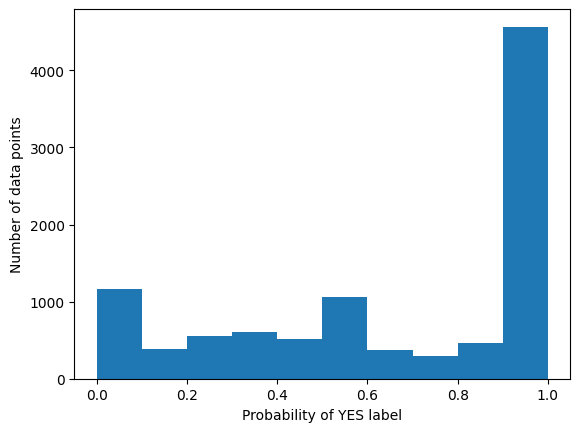

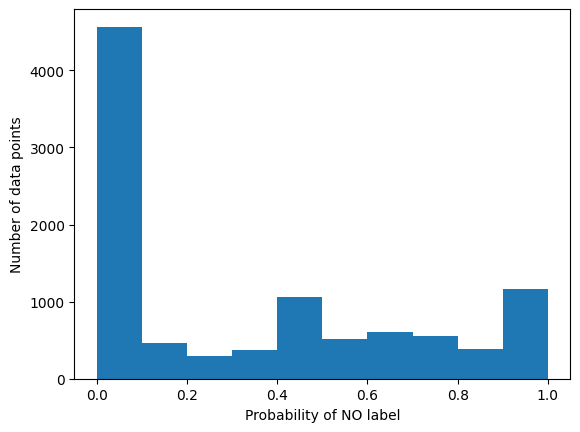

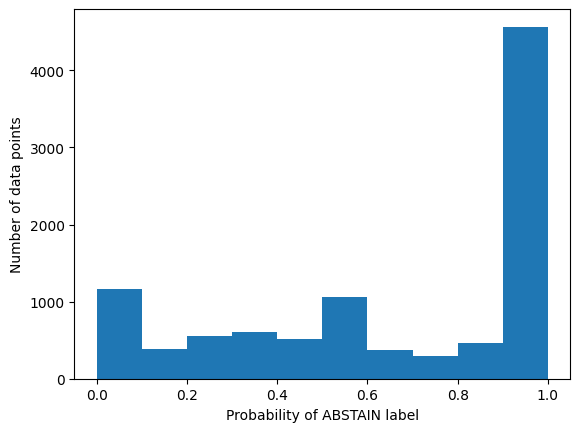

In [ ]:
# Define a function to plot a histogram of the probabilities of the YES label
def plot_probabilities_histogram(Y,texto):
    # Plot a histogram of the probabilities with 10 bins
    plt.hist(Y, bins=10)
    # Set the x-axis label
    plt.xlabel(f"Probability of {texto} label")
    # Set the y-axis label
    plt.ylabel("Number of data points")
    # Show the plot
    plt.show()

# Use the label model to predict label probabilities for the training set
probs_train = label_model.predict_proba(L=L_train)
# Plot a histogram of the probabilities of the YES label
plot_probabilities_histogram(probs_train[:, YES],'YES')
# Plot a histogram of the probabilities of the NO label
plot_probabilities_histogram(probs_train[:, NO],'NO')
# Plot a histogram of the probabilities of the YES label
plot_probabilities_histogram(probs_train[:, ABSTAIN],"ABSTAIN")

Criando o Label model


In [ ]:
from snorkel.labeling import filter_unlabeled_dataframe
# Filtrar todas as instancias que não foram rotuladas por nenhuma label model
df_train_weakly_labeled, probs_train_weakly_labeled = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train)

In [ ]:
if len(df_train_weakly_labeled) == len(df_train):
    print("All data points are weakly labeled!")
else:
    print(f"Number of data points after filtering: {len(df_train_weakly_labeled)} (removed {len(df_train) - len(df_train_weakly_labeled)} data points)")

Number of data points after filtering: 9123 (removed 877 data points)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), strip_accents='unicode', lowercase=True, max_features=1000, max_df=0.85, min_df=3)
vectorizer.fit(df_train.textos_limpos.values)
X_train = vectorizer.transform(df_train.texto.values).toarray()
X_dev = vectorizer.transform(df_dev.texto.values).toarray()

y_dev_true = df_dev.Classificacao_Binaria.values

In [ ]:
y_train_prob_labels = probs_train

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
import tensorflow as tf
import os

def get_model(ip_dim, dim_h1, dim_h3, dim_h5,dim_h7, out_size, dropout, lr):
    x = Input(shape=(ip_dim,))
    h1 = Dense(dim_h1)(x)
    h2 = Dropout(dropout)(h1)
    h3 = Dense(dim_h3, activation='relu')(h2)
    h4 = Dropout(dropout)(h3)
    h5 = Dense(dim_h5, activation='relu')(h4)
    h6 = Dropout(dropout)(h5)
    h7 = Dense(dim_h7,activation = 'sigmoid')(h5)
    h8 = Dropout(dropout)(h7)
    h9 = Dense(out_size, activation='softmax')(h8)
    model = Model(inputs=x, outputs=h9)
    model.compile(optimizers.Adam(lr), 'kullback_leibler_divergence', ['accuracy'])
    #model.compile(optimizers.Adam(lr), 'categorical_crossentropy', ['accuracy'])
    return model





In [ ]:
def train_model_keras(X_train, y_train, X_dev, y_dev):
    ip_dim = X_train.shape[1]
    dim_h1 = 1000
    dim_h3 = 500
    dim_h5 = 300
    dim_h7 = 100

    dropout = 0.1
    lr = 0.0003
    epochs = 20
    batch_size = 256
    out_size = y_train.shape[1]
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

    with tf.device('/cpu:0'): # or /gpu:0
        model_tf = get_model(ip_dim, dim_h1, dim_h3, dim_h5,dim_h7, out_size, dropout, lr)
        # Define a model checkpointing callback to save the best model after each step

        model_tf.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_dev, y_dev), callbacks=[earlystop_callback, checkpoint_callback])

    # Load the weights from the best model
    model_tf.load_weights('best_model.h5')

    # remove the file
    os.remove('best_model.h5')

    return model_tf
def print_metrics(y_true, y_pred):
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    print(f'Classification report for the DL model: \n{classification_report(y_true, y_pred)}')
    print(f'MCC: {matthews_corrcoef(y_true, y_pred)}')
    print(f'ACC: {accuracy_score(y_true, y_pred)}')
    print(f'Confusion matrix: \n{confusion_matrix(y_true, y_pred)}')
    print(f'Trained with {len(y_true)} labels')

In [ ]:
model_tf = train_model_keras(X_train, y_train_prob_labels, X_dev, np.eye(2)[y_dev_true])

Epoch 1/20
40/40 [==============================] - 3s 48ms/step - loss: 0.2191 - accuracy: 0.7094 - val_loss: 0.6663 - val_accuracy: 0.6302
Epoch 2/20
40/40 [==============================] - 2s 42ms/step - loss: 0.0921 - accuracy: 0.8320 - val_loss: 0.7183 - val_accuracy: 0.6527
Epoch 3/20
40/40 [==============================] - 2s 41ms/step - loss: 0.0774 - accuracy: 0.8475 - val_loss: 0.8063 - val_accuracy: 0.6495
Epoch 4/20
40/40 [==============================] - 2s 41ms/step - loss: 0.0700 - accuracy: 0.8509 - val_loss: 0.6859 - val_accuracy: 0.7363
Epoch 5/20
40/40 [==============================] - 2s 40ms/step - loss: 0.0661 - accuracy: 0.8556 - val_loss: 0.7797 - val_accuracy: 0.6849
Epoch 6/20
40/40 [==============================] - 2s 40ms/step - loss: 0.0609 - accuracy: 0.8583 - val_loss: 0.9542 - val_accuracy: 0.6495


In [ ]:
predito_dev= model_tf.predict(X_dev)
verdadeiro_dev=df_dev.Classificacao_Binaria.values


print_metrics(verdadeiro_dev,predito_dev)

10/10 [==============================] - 0s 4ms/step
Classification report for the DL model: 
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       165
           1       0.70      0.99      0.82       146

    accuracy                           0.79       311
   macro avg       0.84      0.81      0.79       311
weighted avg       0.85      0.79      0.79       311

MCC: 0.6443279361525832
ACC: 0.7942122186495176
Confusion matrix: 
[[103  62]
 [  2 144]]
Trained with 311 labels


# Metricas para o utilizando os dados de teste para a validação final

In [ ]:

Y_test=df_teste.Classificacao_Binaria

applier = PandasLFApplier(lfs=lfs)
L_teste = applier.apply(df=df_teste)

label_model.fit(L_train=L_teste, n_epochs=5000, log_freq=100, seed=10)

preds_train = majority_model.predict(L=L_teste)

majority_pred = majority_model.predict(L=L_teste)
label_model_pred = label_model.predict(L=L_teste)

print(f'Classification report for majority model: \n{classification_report(df_teste.Classificacao_Binaria.values, majority_pred)}')
print(f'Number of abstains: {np.count_nonzero(majority_pred == -1)}')
print(f'\n\nClassification report for label model: \n{classification_report(df_teste.Classificacao_Binaria.values, label_model_pred)}')
print(f'Number of abstains: {np.count_nonzero(label_model_pred == -1)}')


X_test = vectorizer.transform(df_teste.texto.values).toarray()

y_test_true = df_teste.Classificacao_Binaria.values

predict_dev= model_tf.predict(X_test)

print_metrics(verdadeiro_dev,predito_dev)






  0%|          | 0/310 [00:00<?, ?it/s]

100%|██████████| 310/310 [00:00<00:00, 357.37it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/5000 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=2.056]
INFO:root:[100 epochs]: TRAIN:[loss=0.042]
100%|██████████| 5000/5000 [00:06<00:00, 819.04epoch/s]
INFO:root:Finished Training
/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/juliano/TRF5/Aprendizado-semi-supervisionado/.venv/lib/python3.10/site-packages/sklea

Classification report for majority model: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       1.00      0.32      0.49       165
           1       0.69      0.99      0.81       145

    accuracy                           0.63       310
   macro avg       0.56      0.44      0.43       310
weighted avg       0.86      0.63      0.64       310

Number of abstains: 51


Classification report for label model: 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.95      0.96      0.95       165
           1       0.95      0.92      0.94       145

    accuracy                           0.94       310
   macro avg       0.63      0.63      0.63       310
weighted avg       0.95      0.94      0.94       310

Number of abstains: 2
10/10 [==============================] - 0s 4ms/step
Classification report for the DL model: 
              

# Conclusões

Nas duas metodologias de voto majoritario quanto de valores probabilisticos e depois usando um modelo descriminativo, no caso uma rede neural, se mostraram com uma performa-se ruim para o caso dos falso negativos, imputando uma quantidade de negativos muito maior do que realmente é o valor verdadeiro.


Dessa maneira será nescessário usar melhores label functions, como a estrategia de transfer learning usando modelos LLM, como o gpt, como tambem o uso de todas as petições na qual não foi possivel devido as limitações de hardware.

Assim, foi possivel aprender os conceitos e caracteristicas do aprendizado semi-supervisionado, que demostra ser uma boa alternativa para o caso dos problemas da justiça onde a sua rotulagem revela-se custosa. E uso desse tipo de metodológia, teve bons casos na literatura, e os resultados encontrados nesse estudo podem ser melhorados com o uso das estrategias descritas acima.

A caracteristica do Dataset ser desbalanceado pode ter interferido na sua perfomance devido que a maioria das petições iniciais utilizadas são de casos que não são referentes a aposentadoria.